In [1]:
import os
import sys
import glob
import json

import numpy as np
import pandas as pd
# from stable_baselines3 import PPO
from tqdm import tqdm

import shap_extractor as se
from helpers import load_agent
from importlib import reload
from pathlib import Path

# from diploma.environment.plot import create_plots

reload(se)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


<module 'shap_extractor' from '/home/justbadcarma/Bachelor/shap_extractor.py'>

In [2]:
import pickle
with open("./data/series2.pkl", "rb") as f:
    series = pickle.load(f)

with open("./data/series23.pkl", "rb") as f:
    series23 = pickle.load(f)

with open("./data/covariates2.pkl", "rb") as f:
    cov = pickle.load(f)

with open("./data/covariates23.pkl", "rb") as f:
    cov23 = pickle.load(f)

In [11]:
full_series=series + series23[100:]

In [12]:
len(full_series)

1006

In [13]:
full_cov = cov+cov23[100:]

In [7]:
full_cov

[<TimeSeries (DataArray) (DATA: 598, component: 4, sample: 1)>
 array([[[ 2.  ],
         [ 2.19],
         [36.  ],
         [39.  ]],
 
        [[ 2.  ],
         [ 3.07],
         [36.  ],
         [39.  ]],
 
        [[ 2.  ],
         [ 2.26],
         [36.  ],
         [39.  ]],
 
        ...,
 
        [[13.  ],
         [ 0.98],
         [70.  ],
         [90.  ]],
 
        [[13.  ],
         [ 0.83],
         [70.  ],
         [90.  ]],
 
        [[13.  ],
         [ 1.21],
         [70.  ],
         [90.  ]]])
 Coordinates:
   * DATA       (DATA) datetime64[ns] 2020-10-02 2020-10-03 ... 2022-05-22
   * component  (component) object 'Number of Available\nTCH' ... 'Param 2'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (DATA: 598, component: 4, sample: 1)>
 array([[[ 3.  ],
         [ 2.5 ],
         [54.  ],
         [78.  ]],
 
        [[ 3.  ],
         [ 2.39],
         [54.  ],
  

In [16]:
list(map(lambda x: x.pd_dataframe(), full_series))

[component   HR Usage Rate  TCH Blocking Rate, BH
 DATA                                            
 2020-10-02          85.03                    0.0
 2020-10-03          86.20                    0.0
 2020-10-04          85.11                    0.0
 2020-10-05          72.78                    0.0
 2020-10-06          70.09                    0.0
 ...                   ...                    ...
 2022-05-18         100.00                    0.0
 2022-05-19         100.00                    0.0
 2022-05-20         100.00                    0.0
 2022-05-21         100.00                    0.0
 2022-05-22         100.00                    0.0
 
 [598 rows x 2 columns],
 component   HR Usage Rate  TCH Blocking Rate, BH
 DATA                                            
 2020-10-02          50.82                    0.0
 2020-10-03          79.38                    0.0
 2020-10-04          76.88                    0.0
 2020-10-05          51.40                    0.0
 2020-10-06          44

In [17]:
df = pd.concat(list(map(lambda x: x.pd_dataframe(), full_series)))

In [18]:
df_cov = pd.concat(list(map(lambda x: x.pd_dataframe(), full_cov)))

In [29]:
full_df = pd.concat([df, df_cov], axis=1)

In [30]:
full_df.columns

Index(['HR Usage Rate', 'TCH Blocking Rate, BH', 'Number of Available\nTCH',
       'TCH Traffic (Erl), BH', 'Param 1', 'Param 2'],
      dtype='object', name='component')

In [31]:
full_df.reset_index(drop=True, inplace=True)
full_df.rename_axis(None, axis=1, inplace=True)
full_df.columns

Index(['HR Usage Rate', 'TCH Blocking Rate, BH', 'Number of Available\nTCH',
       'TCH Traffic (Erl), BH', 'Param 1', 'Param 2'],
      dtype='object')

In [32]:
full_df

,HR Usage Rate,"TCH Blocking Rate, BH",Number of Available\nTCH,"TCH Traffic (Erl), BH",Param 1,Param 2
0,85.03,0.0,2.0,2.19,36.0,39.0
1,86.20,0.0,2.0,3.07,36.0,39.0
2,85.11,0.0,2.0,2.26,36.0,39.0
3,72.78,0.0,2.0,3.29,36.0,39.0
4,70.09,0.0,2.0,2.81,36.0,39.0
...,...,...,...,...,...,...
274869,44.00,0.0,13.0,2.53,26.0,43.0
274870,22.00,0.0,13.0,1.86,26.0,43.0
274871,24.00,0.0,13.0,1.68,26.0,43.0
274872,24.00,0.0,13.0,1.68,26.0,43.0


In [33]:
full_df.to_csv("./data/new_full_param_data.csv")

# Cell agent

In [37]:
# import Bachelor.rl as rl

data_path = 'Bachelor/data/dataset_full.csv'
agent = load_agent('sac_best_enough_qual.pt', 'pt',)

In [34]:
import torch


def preprocess(data: pd.DataFrame):
    df = data.copy()
    cols = ['HR Usage Rate', 'TCH Blocking Rate, BH', 'Number of Available\nTCH',
               'TCH Traffic (Erl), BH', 'Lower_limit', 'Upper_limit']
    df.drop(columns='DATA', inplace=True)
    df.rename(columns={'Param 1': cols[-2], 'Param 2': cols[-1]}, inplace=True)

    df = df[cols].drop(columns=['Cell ID', 'LAC'], errors='ignore')
    df.rename_axis(None, axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df[cols]

def cell_f(x):
    res = agent.act(torch.as_tensor(x, dtype=torch.float32))

    return res



In [12]:
data = pd.read_csv(data_path, index_col=0)

In [13]:
data

,Cell ID,DATA,Number of Available\nTCH,HR Usage Rate,"TCH Blocking Rate, BH","TCH Traffic (Erl), BH",Param 1,Param 2
0,25771,2020-10-02,4.0,94.95,0.00,7.78,56,68
1,25772,2020-10-02,3.0,65.10,0.00,5.74,24,43
2,25773,2020-10-02,3.0,97.38,0.12,13.42,78,92
3,3361,2020-10-02,3.0,97.66,1.22,18.27,90,97
5,3363,2020-10-02,3.0,31.84,0.00,5.10,36,50
...,...,...,...,...,...,...,...,...
1028,882,2022-05-22,13.0,78.00,0.00,1.76,26,43
1029,887,2022-05-22,20.0,50.00,0.00,8.76,12,21
1030,883,2022-05-22,12.0,88.00,0.26,4.23,18,29
1031,888,2022-05-22,12.0,78.00,0.19,8.04,19,31


In [28]:
# from tqdm import tqdm
# 
# expected_values = []
# path = 'data/cell/run_1/'
# 
# for cell in tqdm(data['Cell ID'].unique()):
#     cell_df = data[data['Cell ID'] == cell]
#     cell_df = preprocess(cell_df)
# 
#     path, exp_value = se.extract_shap(cell_df, cell_f, path, f'cell_{cell}')
#     expected_values.append((cell, exp_value))
# 
# exp_df = pd.DataFrame(expected_values, columns=['cell_id', 'expected_value'])
# exp_df.to_csv(os.path.join(path, 'expected_values.csv'))

  0%|          | 0/1043 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 1/1043 [00:03<59:40,  3.44s/it]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 2/1043 [00:07<1:03:17,  3.65s/it]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 3/1043 [00:10<1:00:14,  3.48s/it]

  0%|          | 0/597 [00:00<?, ?it/s]

In [35]:
full_df

,HR Usage Rate,"TCH Blocking Rate, BH",Number of Available\nTCH,"TCH Traffic (Erl), BH",Param 1,Param 2
0,85.03,0.0,2.0,2.19,36.0,39.0
1,86.20,0.0,2.0,3.07,36.0,39.0
2,85.11,0.0,2.0,2.26,36.0,39.0
3,72.78,0.0,2.0,3.29,36.0,39.0
4,70.09,0.0,2.0,2.81,36.0,39.0
...,...,...,...,...,...,...
274869,44.00,0.0,13.0,2.53,26.0,43.0
274870,22.00,0.0,13.0,1.86,26.0,43.0
274871,24.00,0.0,13.0,1.68,26.0,43.0
274872,24.00,0.0,13.0,1.68,26.0,43.0


  0%|          | 0/274874 [00:00<?, ?it/s]

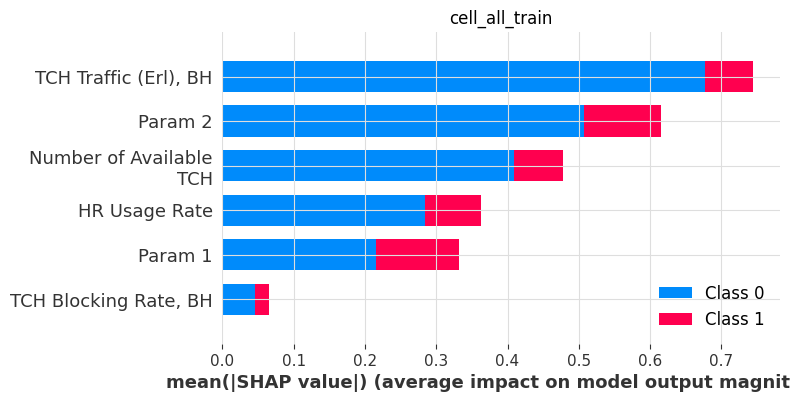

In [38]:
from tqdm import tqdm

expected_values = []
path = 'data/cell/run_1/'

cell_df = full_df.copy()

path, exp_value = se.extract_shap(cell_df, cell_f, path, f'cell_all_train')
expected_values.append(('all_train', exp_value))

exp_df = pd.DataFrame(expected_values, columns=['cell_id', 'expected_value'])
exp_df.to_csv(os.path.join(path, 'expected_values.csv'))

In [24]:
np.ones((2, 10, 6))



array([[[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]]])

# Trading

In [2]:
path_to_json = 'diploma/experiments/16_05_new_reward_window_size_16_ups_False/stop_loss_ne_100_rs_True_eer_False_ffh_0/profits_train/'
list_of_jsons = glob.glob(path_to_json + '*.json')
list_of_jsons = sorted(list_of_jsons)

for json_file in list_of_jsons:
    profits_dict = json.load(open(json_file, "r"))
    print(profits_dict)
    print()
    # break

[['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_11.parquet', -5094.744170488062], ['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_12.parquet', -1401.649470015138], ['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_13.parquet', -43.734246161038755], ['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_14.parquet', -3081.973257076359], ['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_15.parquet', -6144.5723419209535]]

[['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_12.parquet', 10.502853701313143], ['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_13.parquet', 90.56149271692266], ['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_14.parquet', -190.3037156715145], ['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_15.parquet', -983.0158896500943], ['D:\\Studies\\diploma\\data\\1_m_timeframe\\2021_year\\week_16.parquet', 183.61721836135257]]

[['D:\\Studies\\diploma\\data\\1_m_timeframe\

In [3]:
infile = '/media/rid/Files/Datasets/Magister/2021_year/'
use_predefined_scaler = False

In [4]:
list_of_weeks = [f'{infile}week_{i}.parquet' for i in range(10, 20, 1)]

In [5]:
list_of_weeks

['/media/rid/Files/Datasets/Magister/2021_year/week_10.parquet',
 '/media/rid/Files/Datasets/Magister/2021_year/week_11.parquet',
 '/media/rid/Files/Datasets/Magister/2021_year/week_12.parquet',
 '/media/rid/Files/Datasets/Magister/2021_year/week_13.parquet',
 '/media/rid/Files/Datasets/Magister/2021_year/week_14.parquet',
 '/media/rid/Files/Datasets/Magister/2021_year/week_15.parquet',
 '/media/rid/Files/Datasets/Magister/2021_year/week_16.parquet',
 '/media/rid/Files/Datasets/Magister/2021_year/week_17.parquet',
 '/media/rid/Files/Datasets/Magister/2021_year/week_18.parquet',
 '/media/rid/Files/Datasets/Magister/2021_year/week_19.parquet']

In [8]:


from diploma.environment.crypto_env_random_price_new_reward import CryptoEnv

if use_predefined_scaler:
    train_env = False
    if len(list_of_weeks) == 4:
        path_to_scaler = f"{infile}data_scalers_4_days/"
    elif len(list_of_weeks) == 6:
        path_to_scaler = f"{infile}data_scalers_6_days/"
    elif len(list_of_weeks) == 10:
        path_to_scaler = f"{infile}data_scalers_10_days/"
    elif len(list_of_weeks) == 15:
        path_to_scaler = f"{infile}data_scalers_15_days/"
else:
    train_env = True
    path_to_scaler = "diploma/all_scalers/scalers_4/"
    Path(path_to_scaler).mkdir(parents=True, exist_ok=True)

config = {
    'transaction_cost': 0.0001, #0.01
    'window_size': 16,
    'n_shares': 1,
    'n_epochs': 100,
    'train_env': train_env,
    'random_start': True,
    'df_path': infile,
    'path_to_scaler': f"{infile}data_scalers\\",
    'scaler_to_use': 'QuantileTransformer',
    'initial_investment': 100000,
    'end_episode_reward': False,
    'add_metadata': True,
    'fine_for_holding': 0
}

random_start = config['random_start']
n_epochs_for_tune = 10

config.update({'df_path': list_of_weeks[0],
               'train_env': train_env,
               'random_start': random_start})

env = CryptoEnv(config)

model_path = 'diploma/experiments/16_05_new_reward_window_size_16_ups_False/stop_loss_ne_100_rs_True_eer_False_ffh_0/ppo_models/ppo_model_trained_on_week_14.zip'
model = PPO.load(model_path, env=env)

env.close()


100%|██████████| 10065/10065 [00:09<00:00, 1049.68it/s]
You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
def trading_f(x):
    act, _ = model.predict(x)

    return act

In [ ]:
profits = []
expected_values = []
profits_path = 'data/trading/run_1/'
Path(profits_path).mkdir(parents=True, exist_ok=True)
path = profits_path

for idw_test, week_test in enumerate(list_of_weeks[-5:]):
    config.update({'df_path': week_test,
                   'train_env': True,
                   'random_start': False,
                   'initial_investment': 70_000,})

    env = CryptoEnv(config)

    week_test_name = str(Path(week_test.replace('\\', '/')).name)[:7]

    net_json = {0: [],
                1: [],
                2: [],
                3: [],
                4: [],
                5: [],
                6: [],}
    net = []
    actions = []
    positions = []
    share_prices = []
    observations = []

    obs = env.reset()
    for i in tqdm(range(len(env.states) - 2)):
        action, _states = model.predict(obs)
        actions.append(action)
        observations.append(obs)

        obs, rewards, done, info = env.step(action)
        positions.append(env.position)
        share_prices.append(env.current_price)

        current_state_index, balance, own_share, net_worth, profit = env.render()
        net_json[i // 1440].append(net_worth)
        net.append(net_worth)

        # if net_worth - config['initial_investment'] < -2000:
        #     break

    # Close the processes
    env.close()

    for i in range(7):
        profit = net_json[i][-1] - net_json[i][0]
        profits.append((week_test, i, profit))
    #get shap
    week_name = f"week_{week_test[week_test.rfind('week_') + 5: week_test.rfind('.parquet')]}"
    path, exp_value = se.extract_shap(pd.DataFrame(observations), trading_f, path, week_name)
    expected_values.append((week_name, exp_value))

    # fig = create_plots(net, positions, actions, share_prices)
    # fig.savefig(f'{plots_path}results_{week_test_name}.jpg', dpi=300)

exp_df = pd.DataFrame(expected_values, columns=['week', 'expected_value'])
exp_df.to_csv(os.path.join(path, 'expected_values.csv'))

with open(profits_path + f'profits.json', 'w') as f:
    f.write(json.dumps(profits))


100%|██████████| 10063/10063 [00:10<00:00, 965.50it/s] 


  0%|          | 0/10063 [00:00<?, ?it/s]

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 90 iterations, alpha=6.938e-04, previous alpha=6.938e-04, with an active set of 47 regressors.
Regressors in active set degenerate. Dropping a regressor, after 141 iterations, i.e. alpha=1.616e-03, with an active set of 45 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 158 iterations, alpha=8.012e-04, previous alpha=8.002e-04, with an active set of 47 regressors.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 168 iterations, alpha=5.392e-04, previous alpha=5.392e-04, with an active set of 43 regressors.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 62 i